# Drive Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive')

dataset = "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip"

Mounted at /content/drive


## Extract dataset

In [3]:
!unzip -o "/content/drive/My Drive/Thesis/deepfake-detection-master/deepfake_database.zip" -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/deepfake_database/validation/df/162_156.jpg  
  inflating: /content/deepfake_database/validation/df/162_158.jpg  
  inflating: /content/deepfake_database/validation/df/162_16.jpg  
  inflating: /content/deepfake_database/validation/df/162_160.jpg  
  inflating: /content/deepfake_database/validation/df/162_164.jpg  
  inflating: /content/deepfake_database/validation/df/162_168.jpg  
  inflating: /content/deepfake_database/validation/df/162_174.jpg  
  inflating: /content/deepfake_database/validation/df/162_176.jpg  
  inflating: /content/deepfake_database/validation/df/162_18.jpg  
  inflating: /content/deepfake_database/validation/df/162_184.jpg  
  inflating: /content/deepfake_database/validation/df/162_20.jpg  
  inflating: /content/deepfake_database/validation/df/162_22.jpg  
  inflating: /content/deepfake_database/validation/df/162_26.jpg  
  inflating: /content/deepfake_database/validation/df/162_28.jpg  
  i

# Preprocessing

## Folder Paths

In [4]:
import os

directory = os.path.join('deepfake_database', 'train_test')
image_format = '.jpg'

## Store into tf.data.Dataset

In [5]:
from tensorflow.keras.preprocessing import image_dataset_from_directory

BATCH_SIZE = 75

training_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="training",
    interpolation="bilinear",
)

validation_dataset = image_dataset_from_directory(
    directory,
    labels="inferred",
    label_mode="binary",
    class_names=['df', 'real'],
    color_mode="rgb",
    batch_size=BATCH_SIZE,
    image_size=(256, 256),
    shuffle=True,
    seed=123,
    validation_split=0.2,
    subset="validation",
    interpolation="bilinear",
)

Found 12353 files belonging to 2 classes.
Using 9883 files for training.
Found 12353 files belonging to 2 classes.
Using 2470 files for validation.


# Model

## Meso-4

In [6]:
def Meso4(input_shape):

    model = Sequential()
    
    model.add(Conv2D(8, (3, 3), input_shape=input_shape, padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(8, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), padding='same'))

    model.add(Conv2D(16, (5, 5), padding='same', activation = 'relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(4, 4), padding='same'))

    model.add(Flatten())
    model.add(Dropout(0.5))
    model.add(Dense(16))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))

    return model, 'Meso4'

## Model Params

In [7]:
input_shape = (256, 256, 3)
# learning_rate = 0.001
dl_rate = 1
EPOCHS = 50

## LR Decay

In [8]:
import tensorflow as tf
from keras.optimizers.schedules import PiecewiseConstantDecay
step = tf.Variable(0, trainable=False)
boundaries = [1000, 1000, 1000]
values = [0.001, 0.0001, 0.00001, 0.000001]
learning_rate_fn = PiecewiseConstantDecay(
    boundaries, values)

# Later, whenever we perform an optimization step, we pass in the step.
learning_rate = learning_rate_fn(step)



## Compile Model

In [9]:
from keras.models import Model as KerasModel
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Reshape, Concatenate, LeakyReLU
from keras.optimizers import Adam

model, modelName = Meso4(input_shape)
optimizer = Adam(lr = learning_rate)
model.compile(optimizer = optimizer, loss = 'mean_squared_error', metrics = ['accuracy'])
print(modelName)

Meso4


# Training

## Fit Model

In [10]:
history = model.fit(training_dataset, epochs=EPOCHS, validation_data=validation_dataset, verbose = 1)
# model.train_on_batch(images_train, labels_train)
model.save(modelName + '.h5')

Epoch 1/50
132/132 [==============================] - 35s 203ms/step - loss: 0.2700 - accuracy: 0.6149 - val_loss: 0.1891 - val_accuracy: 0.6947
Epoch 2/50
132/132 [==============================] - 26s 194ms/step - loss: 0.1544 - accuracy: 0.7863 - val_loss: 0.1531 - val_accuracy: 0.7636
Epoch 3/50
132/132 [==============================] - 27s 197ms/step - loss: 0.1187 - accuracy: 0.8391 - val_loss: 0.1073 - val_accuracy: 0.8433
Epoch 4/50
132/132 [==============================] - 27s 196ms/step - loss: 0.1042 - accuracy: 0.8599 - val_loss: 0.0948 - val_accuracy: 0.8660
Epoch 5/50
132/132 [==============================] - 26s 195ms/step - loss: 0.0909 - accuracy: 0.8761 - val_loss: 0.0662 - val_accuracy: 0.9130
Epoch 6/50
132/132 [==============================] - 27s 198ms/step - loss: 0.0781 - accuracy: 0.8980 - val_loss: 0.0798 - val_accuracy: 0.8980
Epoch 7/50
132/132 [==============================] - 26s 196ms/step - loss: 0.0666 - accuracy: 0.9165 - val_loss: 0.0777 - val_ac

## Training and Validation Graphs

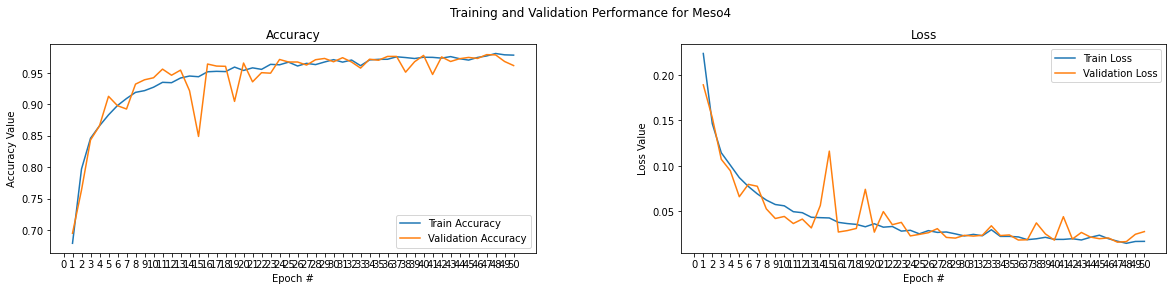

In [11]:
import matplotlib.pyplot as plt
import numpy as np

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))
t = f.suptitle('Training and Validation Performance for ' + modelName, fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,EPOCHS+1))
ax1.plot(epoch_list, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, EPOCHS+1, 1))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch #')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, EPOCHS+1, 1))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch #')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")